## Dissertation

In [1]:
from QuantConnect.Data.Market import TradeBar
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.vecm import VECM
import ta
from sklearn.metrics import accuracy_score
import math
import matplotlib.pyplot as plt
import warnings
from xgboost import XGBClassifier
from arch import arch_model
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.model_selection import TimeSeriesSplit

warnings.filterwarnings("ignore")

# Initialize the QuantBook
qb = QuantBook()

# Define the start and end date
start_date = datetime(2009, 1, 1)
end_date = datetime(2019, 12, 31)

# stocks = ['AAPL','C','JPM','MCD']
stocks = ['AAPL', 'C', 'JPM', 'MCD' , 'XOM', 'AMZN']
# stocks = ['AAPL']

# stocks = ['AAPL']

# Dictionary to store the df_returns for each stock
df_returns_dict = {}

# Dictionary to store predictions for each stock
predictions_table_dict = {}

# Dictionary to store the overall train-test accuracy for each stock
train_test_accuracy_dict = {}

# Initialize a dictionary to store the best hyperparameters for each stock
best_params_dict = {}

# Initialise df containing ROC curve information
ROC_dict = {}

# Initalise Volatility Hyperparameters
vol_params_dict = {}


# Define the parameter distribution
param_grid_rf = {
    'n_estimators': [50, 100, 200, 300],       # Number of trees
    'max_depth': [None, 5, 10, 20],            # Maximum depth of the tree
    # 'min_samples_split': randint(2, 11),       # Minimum samples to split a node
    # 'min_samples_leaf': randint(1, 5),         # Minimum samples at a leaf node
    'bootstrap': [True, False]                 # Whether to use bootstrap samples
}

param_grid_xgb = {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7],
            }

# Define TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)  # Number of splits

In [2]:
for stock in stocks:

    # Add the stock to the QuantBook
    stock_data = qb.AddEquity(stock)

    # Fetch the historical data
    stock_history = qb.History(stock_data.Symbol, start_date, end_date, Resolution.Daily)

    # Convert the historical data to a DataFrame
    stock_df = stock_history.reset_index().pivot(index='time', columns='symbol', values=['open', 'high', 'low', 'close', 'volume'])
    stock_df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    stock_df.index = pd.DatetimeIndex(stock_df.index)

     # Smooth the data and calculate the Technical indicators
    stock_df['Smoothed_Close'] = stock_df['Close'].ewm(alpha=0.095).mean()
    stock_df['RSI'] = ta.momentum.rsi(stock_df['Smoothed_Close'])
    stock_df['SO'] = ta.momentum.stoch(stock_df['High'], stock_df['Low'], stock_df['Smoothed_Close'])
    stock_df['MACD'] = ta.trend.macd_diff(stock_df['Smoothed_Close'])
    stock_df['PROC'] = ta.momentum.roc(stock_df['Smoothed_Close'])
    stock_df['OBV'] = ta.volume.on_balance_volume(stock_df['Close'], stock_df['Volume'])

    # stock_df = stock_df.iloc[::21]  # Select every 21st day

    # Calculate the target variable according to the new formula
    # Predict the sign of the log of the quotient (price 21 days ahead/current price)
    stock_df['Return'] = stock_df['Close']/stock_df['Close'].shift(21)
    stock_df['Log_Return'] = np.log(stock_df['Close'] / stock_df['Close'].shift(21))
    stock_df['Target'] = np.sign(stock_df['Log_Return'])

    # stock_df['Target_check'] = np.sign(stock_df['Close']/stock_df['Close'].shift(1) - 1)

    stock_df.fillna(method='bfill', inplace=True)

    # print(stock_df['Target_check'] == stock_df['Target'])

    # Map [-1,1] to [0,1] for XGB
    stock_df['Target'] = (stock_df['Target'] == 1).astype(int) # Calculate technical indicators every 21 days

    features = stock_df[['RSI', 'SO', 'MACD', 'PROC', 'OBV']].dropna()
    target = stock_df['Target'].dropna().astype(int)  # Convert the target to integer for classification purposes
    features, target = features.align(target, join='inner', axis=0)

    # Total number of observations
    total_observations = len(features)  # Important: Use features here since it's aligned with target

    # Rolling window calculations
    rolling_window_length = int(total_observations * 0.8)
    train_length = int(rolling_window_length * 0.8)
    test_length = rolling_window_length - train_length

    # Initialize storage for predictions and actual values
    predictions_table = pd.DataFrame(columns=['Date', 'Actual', 'XGB_Prediction','RF_Prediction'])
    i = 0

    # Initialize a DataFrame to store the train-test accuracy for each rolling window of each stock
    train_test_table = pd.DataFrame(columns=['Train-test start date', 'Window end'])

    forecasted_returns_garch = []
    actual_returns_list = []

    # Initialize lists for storing forecasted prices and actual prices for plotting
    # forecasted_prices = []
    # actual_prices = []

    # Initialize a DataFrame to store the predicted returns, actual returns, and dates
    df_returns = pd.DataFrame(columns=['Date', 'Predicted_Return_RF','Predicted_Return_XGB', 'Actual_Return'])

    ROC_df = pd.DataFrame()

    # Initalise for each stock to allow hyper-parammeter tuning
    first_window_done = False

    # Loop through the dataset with a step of 21 days for each rolling window
    for start in range(0, total_observations - rolling_window_length - 21, 21):
        i += 1
        train_end = start + train_length
        test_end = train_end + test_length
        
        X_train = features.iloc[start:train_end]
        y_train = target.iloc[start:train_end]
        X_test = features.iloc[train_end:test_end]
        y_test = target.iloc[train_end:test_end]

        # Check if hyper-parammeters have been tuned
        if not first_window_done:

            if f'{stock}_rf' not in best_params_dict:
                model_rf = RandomForestClassifier(random_state=42)
                grid_search_rf = GridSearchCV(estimator=model_rf, param_grid=param_grid_rf, cv=tscv, scoring='accuracy')
                grid_search_rf.fit(X_train, y_train)
                best_params_rf = grid_search_rf.best_params_
                print(f"Best Parameters RF: {best_params_rf}")

                # Initialize the model
                model_xgb = XGBClassifier(random_state=42,eval_metric='logloss')
                grid_search_xgb = GridSearchCV(estimator=model_xgb, param_grid=param_grid_xgb, cv=tscv, scoring='accuracy')
                grid_search_xgb.fit(X_train, y_train)
                best_params_xgb = grid_search_xgb.best_params_
                print(f"Best parameters XGB: {best_params_xgb}")


                best_params_dict[f'{stock}_rf'] = best_params_rf
                best_params_dict[f'{stock}_xgb'] = best_params_xgb

                first_window_done = True

                '''ROC curve calculations'''

                model_rf = RandomForestClassifier(**best_params_rf,random_state=42)
                model_rf.fit(X_train,y_train)
                y_score_rf = model_rf.predict_proba(X_test)[:, 1]

                # Compute ROC curve and AUC for the test set
                fpr_rf, tpr_rf, _ = roc_curve(y_test, y_score_rf)
                roc_auc_rf = auc(fpr_rf, tpr_rf)

                model_xgb = XGBClassifier(**best_params_xgb,eval_metric='logloss',random_state=42)
                model_xgb.fit(X_train, y_train)
                y_score_xgb = model_xgb.predict_proba(X_test)[:, 1]

                # Compute ROC curve and AUC for the test set
                fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_score_xgb)
                roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

                # Store this prediction in the table 
                new_ROC = pd.DataFrame([{
                    'fpr_rf': fpr_rf,
                    'tpr_rf': tpr_rf,
                    'roc_auc_rf': roc_auc_rf,
                    'fpr_xgb': fpr_xgb,
                    'tpr_xgb': tpr_xgb,
                    'roc_auc_xgb': roc_auc_xgb,
                }])
                ROC_df = pd.concat([ROC_df, new_ROC], ignore_index=True)
            
            else:
                pass


        # Fit the hypertunned model
        model_rf = RandomForestClassifier(**best_params_rf,random_state=42)
        model_rf.fit(X_train,y_train)

        # Train XGB
        # model_xgb = XGBClassifier(n_estimators=100, learning_rate=0.01, max_depth=3, use_label_encoder=False, eval_metric='logloss')
        model_xgb = XGBClassifier(**best_params_xgb,eval_metric='logloss',random_state=42)
        model_xgb.fit(X_train, y_train)

        xgb_test_predictions = model_xgb.predict(X_test)
        rf_test_predictions = model_rf.predict(X_test)

        # Calculate the testing metrics
        xgb_accuracy = accuracy_score(y_test, xgb_test_predictions) # accuracy
        xgb_precision = precision_score(y_test, xgb_test_predictions, average='binary') # precision
        xgb_recall = recall_score(y_test, xgb_test_predictions, average='binary') # recall
        xgb_f1 = f1_score(y_test, xgb_test_predictions, average='binary') # F1 score

        # Calculate the testing metrics
        rf_accuracy = accuracy_score(y_test, rf_test_predictions) # accuracy
        rf_precision = precision_score(y_test, rf_test_predictions, average='binary') # precision
        rf_recall = recall_score(y_test, rf_test_predictions, average='binary') # recall
        rf_f1 = f1_score(y_test, rf_test_predictions, average='binary') # F1 score

        
        # Print testing accuracy for the current window
        # print(f"Train start: {X_train.index[0]} Train end: {X_train.index[-1]} Test start: {X_test.index[0]} Test end: {X_test.index[-1]}, XGB Testing Accuracy = {xgb_accuracy:.2f}")
        # print(f"XGB Testing Accuracy = {xgb_accuracy:.2f}, RF Testing Accuracy = {rf_accuracy:.2f}")

        # Make a one-month ahead prediction
        prediction_date = target.index[test_end + 21  : (test_end + 22)]
        prediction_date = prediction_date[-1]
        X = features.iloc[test_end + 21 : (test_end + 22)]
        
        # Prediction from models
        xgb_pred = model_xgb.predict(X)
        xgb_pred = xgb_pred[-1]
        rf_pred = model_rf.predict(X)
        rf_pred = rf_pred[-1]
        
        # Convert from [0,1] to [-1, 1] for XGB
        xgb_pred_direction = 1 if xgb_pred == 1 else -1

        # Convert from [0,1] to [-1, 1] for RF
        rf_pred_direction = 1 if rf_pred == 1 else -1

        # Actual Direction Change
        actual = target.iloc[test_end + 21: (test_end + 22)]
        actual = actual[-1]

        # Convert from [0,1] to [-1, 1] for actual value
        actual = 1 if actual == 1 else -1

        print(f"window {i} date: {prediction_date} XGB: {xgb_pred_direction} RF: {rf_pred_direction} actual {actual}")


        '''Volatility Modelling Section'''
        
        if stock not in vol_params_dict:

            # Fit GARCH model on the log returns of the training set
            log_returns = stock_df['Log_Return'][start:test_end+21]

            # Define the range of p and q values to test
            p_values = range(1, 4)  # for example, testing p=1,2,3
            q_values = range(1, 4)  # for example, testing q=1,2,3

            # Placeholder for the best GARCH model fit and its AIC
            best_aic = float('inf')
            best_garch_fit = None
            best_p = None
            best_q = None

            # Loop through all combinations of p and q to find the best model
            for p in p_values:
                for q in q_values:
                    try:
                        # Fit the GARCH model with current p and q values
                        garch = arch_model(log_returns, vol='Garch', p=p, q=q)
                        garch_fit = garch.fit(disp='off')
                        
                        # Check if the current model has a lower AIC than the previous best
                        if garch_fit.aic < best_aic:
                            best_aic = garch_fit.aic
                            best_garch_fit = garch_fit
                            best_p = p
                            best_q = q
                    except Exception as e:
                        print(f"An error occurred for p={p}, q={q}: {e}")

            # Fit the best GARCH model selected to data
            print(f"best p:{best_p} best q: {best_q}")

            vol_params_dict[stock] =  {p:best_p , q:best_q}
        


        # Fit GARCH model on the log returns of the training set
        log_returns = stock_df['Log_Return'][start:test_end+21]

        # Define the range of p and q values to test
        p_values = range(1, 4)  # for example, testing p=1,2,3
        q_values = range(1, 4)  # for example, testing q=1,2,3

        # Placeholder for the best GARCH model fit and its AIC
        best_aic = float('inf')
        best_garch_fit = None
        best_p = None
        best_q = None

        # Loop through all combinations of p and q to find the best model
        for p in p_values:
            for q in q_values:
                try:
                    # Fit the GARCH model with current p and q values
                    garch = arch_model(log_returns, vol='Garch', p=p, q=q)
                    garch_fit = garch.fit(disp='off')
                    
                    # Check if the current model has a lower AIC than the previous best
                    if garch_fit.aic < best_aic:
                        best_aic = garch_fit.aic
                        best_garch_fit = garch_fit
                        best_p = p
                        best_q = q
                except Exception as e:
                    print(f"An error occurred for p={p}, q={q}: {e}")

        # Fit the best GARCH model selected to data
        print(f"best p:{best_p} best q: {best_q}")
        
        garch = arch_model(log_returns, vol='Garch', p=best_p, q=best_q)
        # garch = arch_model(log_returns, vol='Garch', p=1, q=1)
        garch_fit = garch.fit(disp='off')

        # Forecast the volatility for the next 21 trading days 
        # Standard Deviation
        forecast_volatility = garch_fit.forecast(horizon=1).variance.iloc[-1].values[-1]**0.5

        # Expected return test
        log_expected_ret_xgb = forecast_volatility * xgb_pred_direction
        expected_ret_xgb = np.exp(log_expected_ret_xgb) - 1

        log_expected_ret_rf = forecast_volatility * rf_pred_direction
        expected_ret_rf = np.exp(log_expected_ret_rf) - 1


        # # Derive from the expected return, the price 1 month ahead
        # # Actual price
        # actual_price = stock_df['Close'][test_end + 1]  # Actual price at the end of the test set

        # # Store the forecasted and actual prices
        # actual_prices.append(actual_price)
        
        # Actual return calculation
        actual_return = np.nan  # Initialize with nan in case there's not enough data
        if test_end + 21 < len(stock_df):
            actual_return = (stock_df['Close'].iloc[test_end + 21]/stock_df['Close'].iloc[test_end]) - 1
        
        # print(f"vol forecast: {forecast_volatility} expected ret: {expected_ret} actual return: {actual_return}")

        new_row_df_returns = pd.DataFrame([{
            'Date': prediction_date,
            'Predicted_Return_RF': expected_ret_rf,
            'Predicted_Return_XGB': expected_ret_xgb,
            'Actual_Return': actual_return
        }])
        df_returns = pd.concat([df_returns, new_row_df_returns], ignore_index=True)

        # Store this prediction in the table 
        new_row_predictions_table = pd.DataFrame([{
            'Date': prediction_date,
            'Actual': actual,
            'XGB_Prediction': xgb_pred_direction,
            'RF_Prediction':rf_pred_direction
        }])
        predictions_table = pd.concat([predictions_table, new_row_predictions_table], ignore_index=True)

        # Store the window accuracy and add to the dictionary 
        new_row_train_test_table = pd.DataFrame([{
            'Train-test start date': X_train.index[0],
            'Window end': X_test.index[-1],
            'Testing accuracy XGB': xgb_accuracy,
            'Recall XGB': xgb_recall,
            'Precision XGB': xgb_precision,
            'F1 XGB': xgb_f1,
            'Testing accuracy RF': rf_accuracy,
            'Recall RF': rf_recall,
            'Precision RF': rf_precision,
            'F1 RF': rf_f1
        }])
        train_test_table = pd.concat([train_test_table, new_row_train_test_table], ignore_index=True)


    predictions_table_dict[stock] = predictions_table
    df_returns_dict[stock] = df_returns
    train_test_accuracy_dict[stock] = train_test_table
    ROC_dict[stock] = ROC_df



Best Parameters RF: {'bootstrap': False, 'max_depth': 5, 'n_estimators': 50}
Best parameters XGB: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
window 1 date: 2017-11-15 16:00:00 XGB: 1 RF: 1 actual 1
best p:3 best q: 1
best p:3 best q: 1
window 2 date: 2017-12-15 16:00:00 XGB: -1 RF: -1 actual 1
best p:3 best q: 1
window 3 date: 2018-01-18 16:00:00 XGB: 1 RF: 1 actual 1
best p:3 best q: 1
window 4 date: 2018-02-16 16:00:00 XGB: -1 RF: -1 actual -1
best p:3 best q: 1
window 5 date: 2018-03-20 16:00:00 XGB: 1 RF: 1 actual 1
best p:3 best q: 1
window 6 date: 2018-04-19 16:00:00 XGB: 1 RF: 1 actual -1
best p:3 best q: 1
window 7 date: 2018-05-18 16:00:00 XGB: 1 RF: 1 actual 1
best p:3 best q: 1
window 8 date: 2018-06-19 16:00:00 XGB: 1 RF: 1 actual -1
best p:3 best q: 1
window 9 date: 2018-07-19 16:00:00 XGB: 1 RF: 1 actual 1
best p:3 best q: 1
window 10 date: 2018-08-17 16:00:00 XGB: 1 RF: 1 actual 1
best p:3 best q: 1
window 11 date: 2018-09-18 16:00:00 XGB: 1 RF: 1 actua

/opt/miniconda3/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


window 13 date: 2018-11-15 16:00:00 XGB: -1 RF: -1 actual -1
best p:3 best q: 1


/opt/miniconda3/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


window 14 date: 2018-12-18 16:00:00 XGB: -1 RF: -1 actual -1
best p:3 best q: 1
window 15 date: 2019-01-18 16:00:00 XGB: -1 RF: -1 actual -1
best p:3 best q: 1
window 16 date: 2019-02-20 16:00:00 XGB: 1 RF: 1 actual 1
best p:3 best q: 1
window 17 date: 2019-03-21 16:00:00 XGB: 1 RF: 1 actual 1
best p:3 best q: 1
window 18 date: 2019-04-22 16:00:00 XGB: 1 RF: 1 actual 1
best p:3 best q: 2
window 19 date: 2019-05-21 16:00:00 XGB: -1 RF: -1 actual -1
best p:3 best q: 1
window 20 date: 2019-06-20 16:00:00 XGB: 1 RF: 1 actual 1
best p:3 best q: 1
window 21 date: 2019-07-22 16:00:00 XGB: 1 RF: 1 actual 1
best p:3 best q: 1
window 22 date: 2019-08-20 16:00:00 XGB: -1 RF: -1 actual 1
best p:3 best q: 1
window 23 date: 2019-09-19 16:00:00 XGB: 1 RF: 1 actual 1
best p:3 best q: 1
window 24 date: 2019-10-18 16:00:00 XGB: 1 RF: 1 actual 1
best p:3 best q: 1
window 25 date: 2019-11-18 16:00:00 XGB: 1 RF: 1 actual 1
best p:3 best q: 1
window 26 date: 2019-12-18 16:00:00 XGB: 1 RF: 1 actual 1
best p:

/opt/miniconda3/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/miniconda3/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


best p:1 best q: 3
window 2 date: 2017-12-15 16:00:00 XGB: 1 RF: 1 actual 1


/opt/miniconda3/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


best p:1 best q: 3
window 3 date: 2018-01-18 16:00:00 XGB: 1 RF: 1 actual 1
best p:1 best q: 1
window 4 date: 2018-02-16 16:00:00 XGB: -1 RF: -1 actual -1
best p:1 best q: 1
window 5 date: 2018-03-20 16:00:00 XGB: -1 RF: -1 actual -1
best p:1 best q: 1
window 6 date: 2018-04-19 16:00:00 XGB: 1 RF: -1 actual -1
best p:1 best q: 1
window 7 date: 2018-05-18 16:00:00 XGB: 1 RF: 1 actual 1
best p:1 best q: 1
window 8 date: 2018-06-19 16:00:00 XGB: -1 RF: -1 actual -1
best p:1 best q: 1
window 9 date: 2018-07-19 16:00:00 XGB: 1 RF: 1 actual 1
best p:1 best q: 1
window 10 date: 2018-08-17 16:00:00 XGB: -1 RF: -1 actual 1
best p:1 best q: 1
window 11 date: 2018-09-18 16:00:00 XGB: -1 RF: -1 actual 1
best p:1 best q: 1
window 12 date: 2018-10-17 16:00:00 XGB: -1 RF: -1 actual -1
best p:1 best q: 1
window 13 date: 2018-11-15 16:00:00 XGB: -1 RF: -1 actual -1
best p:1 best q: 1
window 14 date: 2018-12-18 16:00:00 XGB: -1 RF: -1 actual -1
best p:1 best q: 1
window 15 date: 2019-01-18 16:00:00 XGB:

/opt/miniconda3/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/miniconda3/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


window 10 date: 2018-08-17 16:00:00 XGB: 1 RF: 1 actual 1
best p:1 best q: 1
window 11 date: 2018-09-18 16:00:00 XGB: 1 RF: 1 actual 1
best p:1 best q: 1
window 12 date: 2018-10-17 16:00:00 XGB: -1 RF: -1 actual -1
best p:3 best q: 1
window 13 date: 2018-11-15 16:00:00 XGB: -1 RF: -1 actual -1
best p:3 best q: 1
window 14 date: 2018-12-18 16:00:00 XGB: 1 RF: 1 actual -1
best p:3 best q: 1
window 15 date: 2019-01-18 16:00:00 XGB: 1 RF: 1 actual 1
best p:3 best q: 1
window 16 date: 2019-02-20 16:00:00 XGB: -1 RF: -1 actual -1
best p:3 best q: 1
window 17 date: 2019-03-21 16:00:00 XGB: 1 RF: 1 actual 1
best p:2 best q: 1
window 18 date: 2019-04-22 16:00:00 XGB: 1 RF: 1 actual 1
best p:3 best q: 1
window 19 date: 2019-05-21 16:00:00 XGB: -1 RF: -1 actual -1
best p:3 best q: 1
window 20 date: 2019-06-20 16:00:00 XGB: 1 RF: 1 actual 1
best p:3 best q: 1
window 21 date: 2019-07-22 16:00:00 XGB: 1 RF: 1 actual 1
best p:3 best q: 1
window 22 date: 2019-08-20 16:00:00 XGB: -1 RF: -1 actual -1
be

In [3]:
vol_params_dict

{'AAPL': {3: 1},
 'C': {3: 3},
 'JPM': {3: 1},
 'MCD': {3: 1},
 'XOM': {3: 1},
 'AMZN': {3: 1}}

In [4]:
for stock in stocks:

    rf_final_accuracy = (predictions_table_dict[stock]['Actual'] == predictions_table_dict[stock]['RF_Prediction']).astype(int).sum()/len(predictions_table_dict[stock])
    print(f'{stock} rf: {rf_final_accuracy:.2f}')


    xgb_final_accuracy = (predictions_table_dict[stock]['Actual'] == predictions_table_dict[stock]['XGB_Prediction']).astype(int).sum()/len(predictions_table_dict[stock])
    print(f'{stock} xgb: {xgb_final_accuracy:.2f}')



AAPL rf: 0.81
AAPL xgb: 0.81
C rf: 0.88
C xgb: 0.85
JPM rf: 0.85
JPM xgb: 0.81
MCD rf: 0.88
MCD xgb: 0.88
XOM rf: 0.88
XOM xgb: 0.88
AMZN rf: 0.88
AMZN xgb: 0.85


In [5]:
best_params_dict

{'AAPL_rf': {'bootstrap': False, 'max_depth': 5, 'n_estimators': 50},
 'AAPL_xgb': {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300},
 'C_rf': {'bootstrap': True, 'max_depth': 5, 'n_estimators': 50},
 'C_xgb': {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100},
 'JPM_rf': {'bootstrap': True, 'max_depth': 5, 'n_estimators': 100},
 'JPM_xgb': {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100},
 'MCD_rf': {'bootstrap': True, 'max_depth': 5, 'n_estimators': 300},
 'MCD_xgb': {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200},
 'XOM_rf': {'bootstrap': True, 'max_depth': 5, 'n_estimators': 100},
 'XOM_xgb': {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300},
 'AMZN_rf': {'bootstrap': False, 'max_depth': 5, 'n_estimators': 300},
 'AMZN_xgb': {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}}

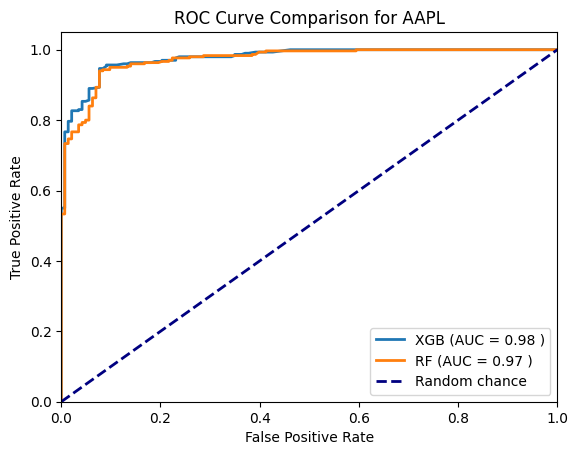

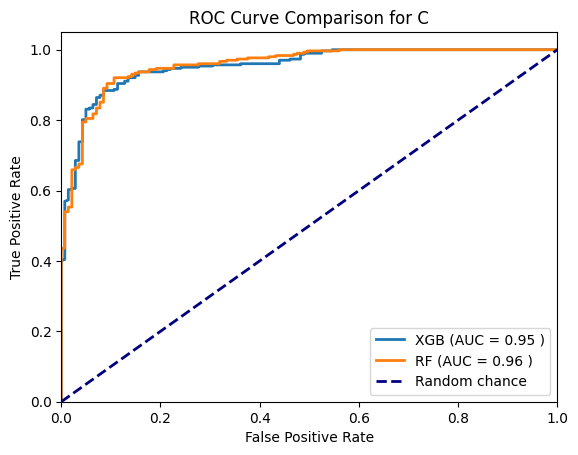

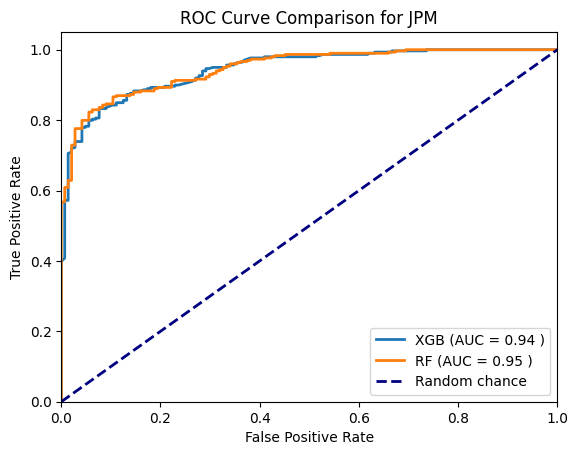

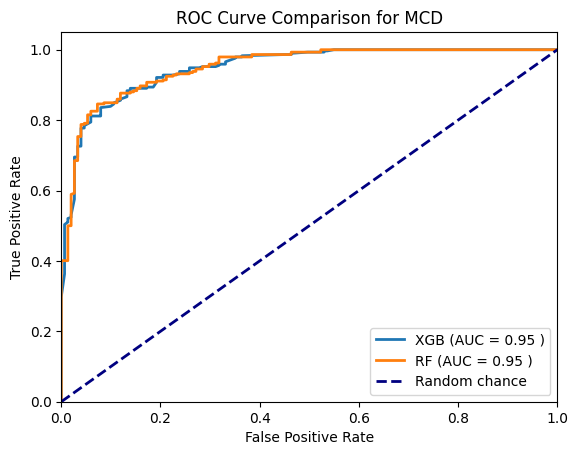

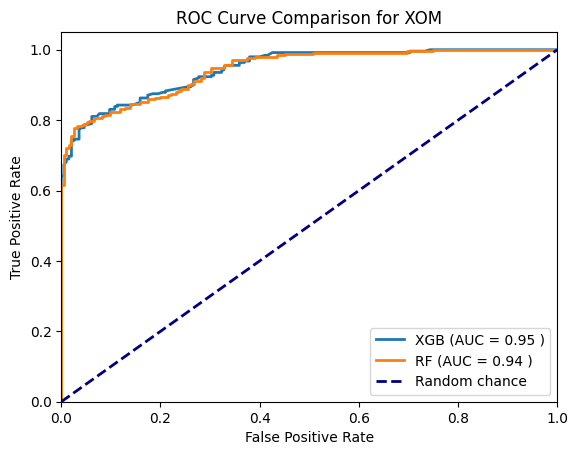

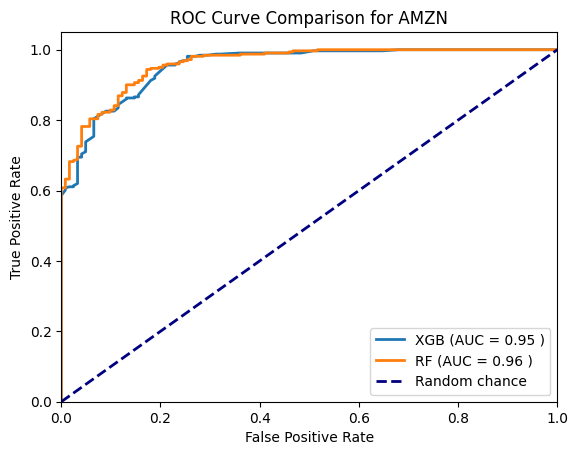

In [6]:
for stock in stocks:
    plt.plot(
    ROC_dict[stock]['fpr_xgb'].iloc[0], 
    ROC_dict[stock]['tpr_xgb'].iloc[0], 
    lw=2, 
    label=f"XGB (AUC = {ROC_dict[stock]['roc_auc_xgb'].iloc[0]:.2f} )"
    )
    plt.plot(
    ROC_dict[stock]['fpr_rf'].iloc[0], 
    ROC_dict[stock]['tpr_rf'].iloc[0], 
    lw=2, 
    label=f"RF (AUC = {ROC_dict[stock]['roc_auc_rf'].iloc[0]:.2f} )"
    )


    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random chance')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # plt.title(f'{stock} Stock ROC Curves for Various Classifiers')
    plt.title(f"ROC Curve Comparison for {stock}")
    plt.legend(loc="lower right")
    plt.show()

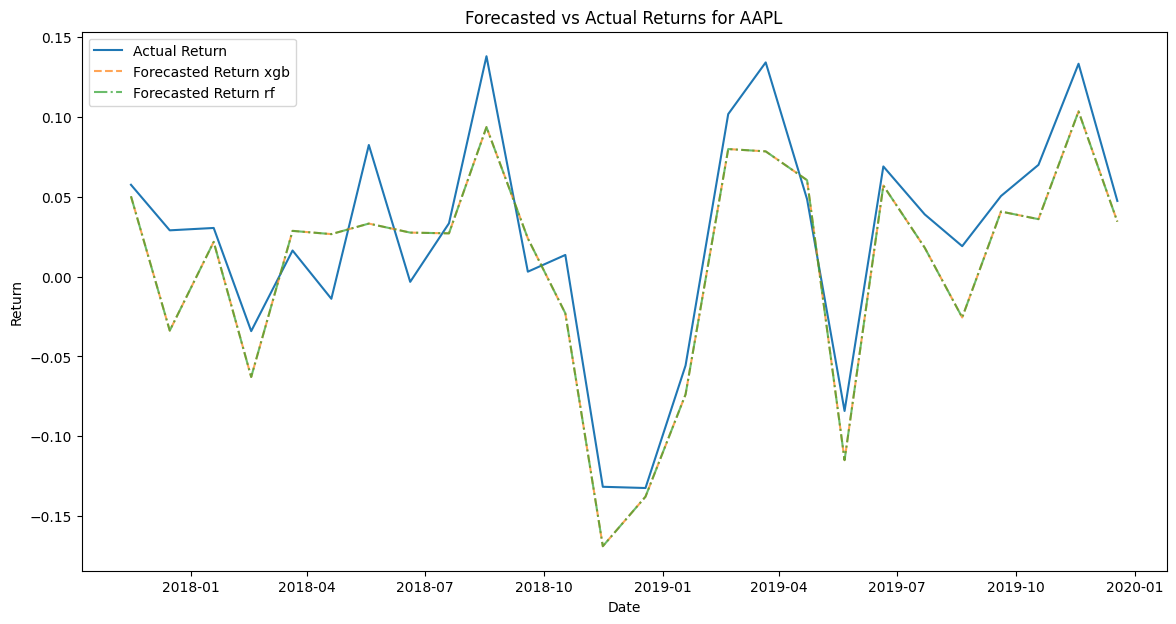

Mean absolute error for XGB AAPL: 0.03
Mean absolute error for RF AAPL: 0.03
Root mean square error (RMSE) for XGB AAPL: 0.03
Root mean square error (RMSE) for RF AAPL: 0.03


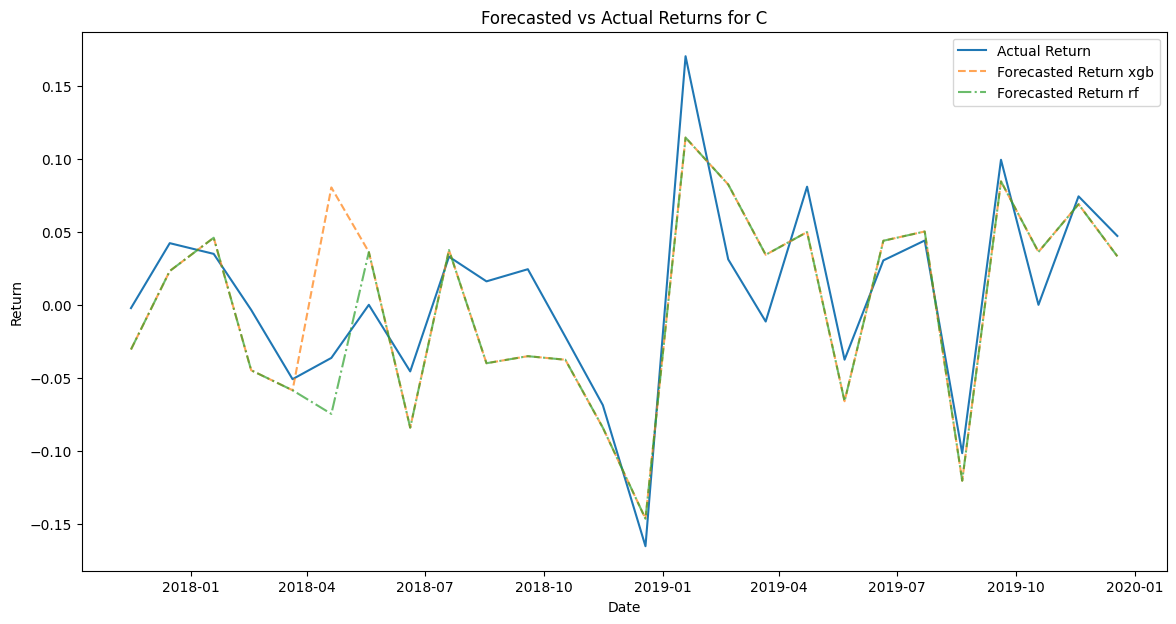

Mean absolute error for XGB C: 0.03
Mean absolute error for RF C: 0.03
Root mean square error (RMSE) for XGB C: 0.04
Root mean square error (RMSE) for RF C: 0.03


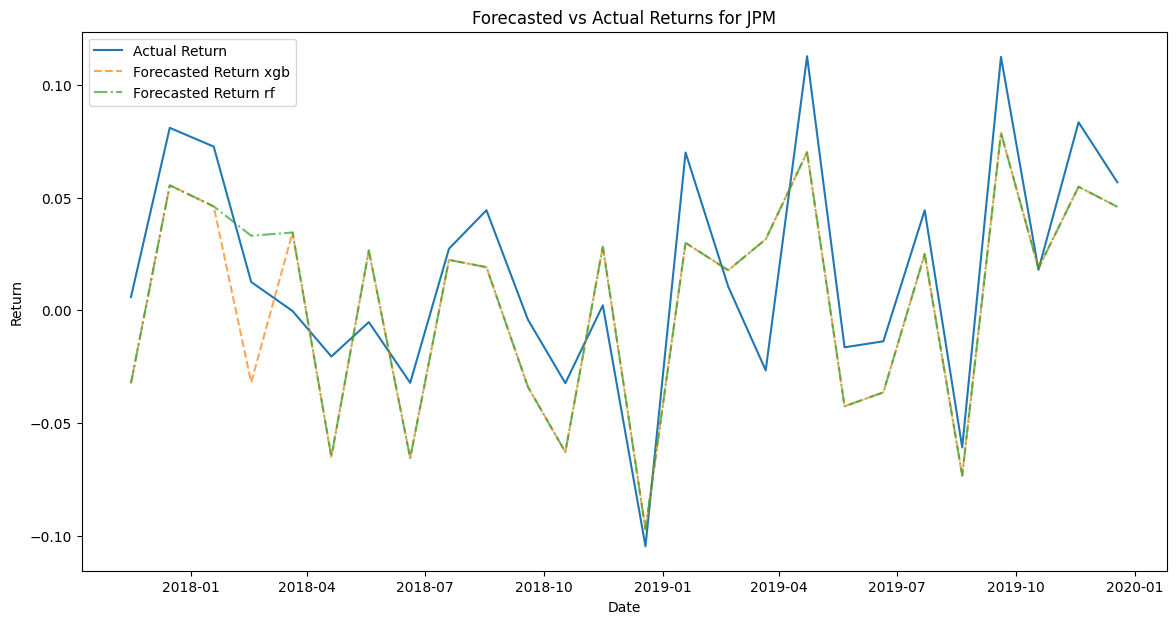

Mean absolute error for XGB JPM: 0.03
Mean absolute error for RF JPM: 0.03
Root mean square error (RMSE) for XGB JPM: 0.03
Root mean square error (RMSE) for RF JPM: 0.03


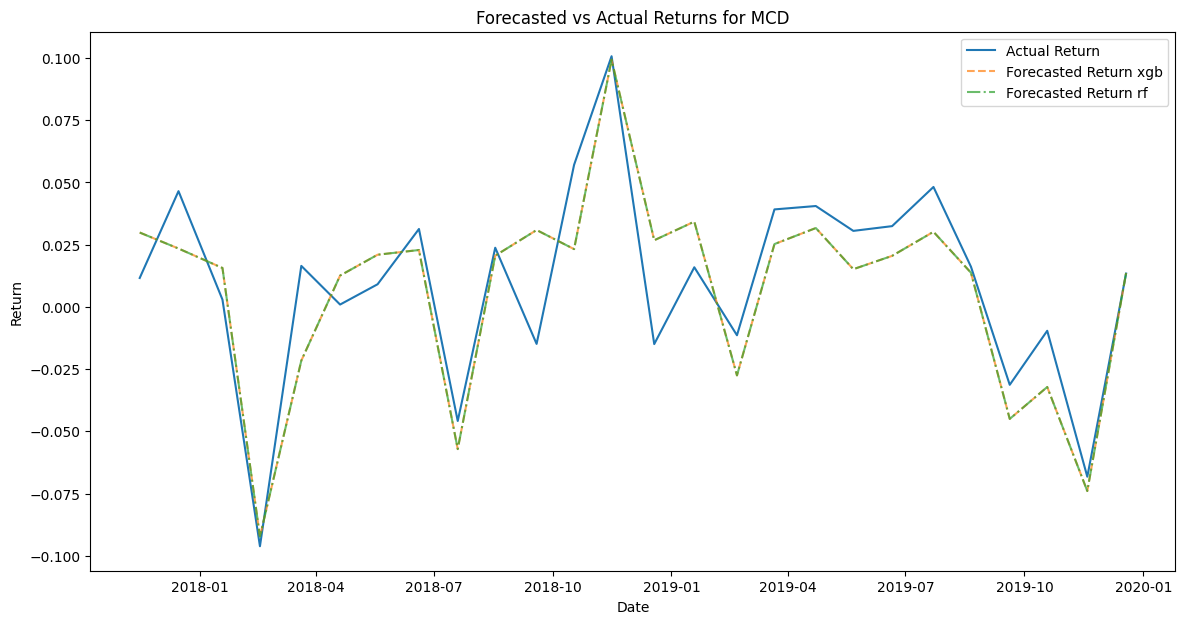

Mean absolute error for XGB MCD: 0.02
Mean absolute error for RF MCD: 0.02
Root mean square error (RMSE) for XGB MCD: 0.02
Root mean square error (RMSE) for RF MCD: 0.02


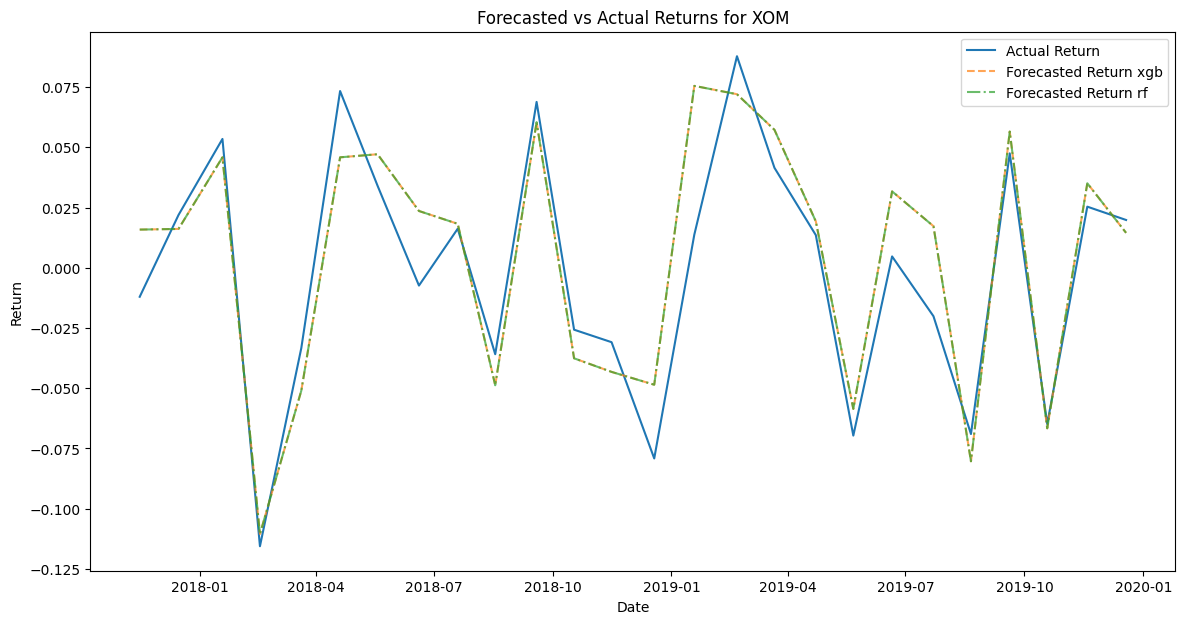

Mean absolute error for XGB XOM: 0.02
Mean absolute error for RF XOM: 0.02
Root mean square error (RMSE) for XGB XOM: 0.02
Root mean square error (RMSE) for RF XOM: 0.02


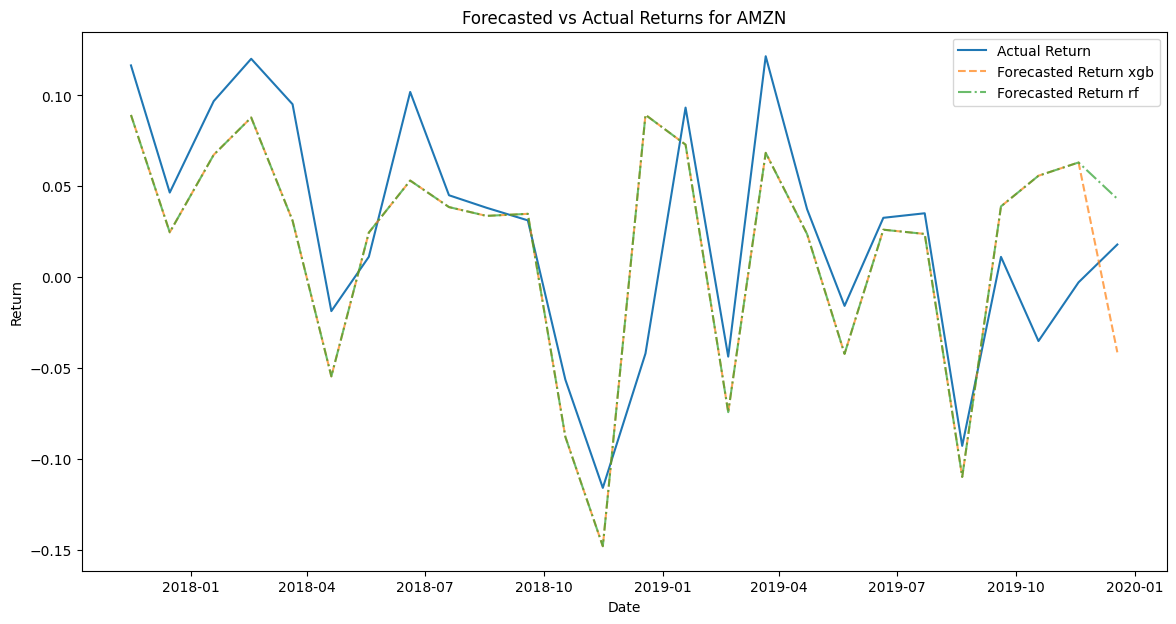

Mean absolute error for XGB AMZN: 0.03
Mean absolute error for RF AMZN: 0.03
Root mean square error (RMSE) for XGB AMZN: 0.05
Root mean square error (RMSE) for RF AMZN: 0.04


In [7]:
# Now, iterate through the df_returns_dict to plot forecasted vs actual returns for each pair
for stock, df_returns in df_returns_dict.items():
    plt.figure(figsize=(14, 7))
    plt.plot(df_returns['Date'], df_returns['Actual_Return'], label='Actual Return')
    plt.plot(df_returns['Date'], df_returns['Predicted_Return_XGB'], label='Forecasted Return xgb', alpha=0.7, linestyle='--')
    plt.plot(df_returns['Date'], df_returns['Predicted_Return_RF'], label='Forecasted Return rf', alpha=0.7, linestyle='-.')
    plt.title(f'Forecasted vs Actual Returns for {stock}')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.legend()
    plt.show()

    # Calculate and print MAE and RMSE for each pair
    mae = np.mean(np.abs(df_returns['Predicted_Return_XGB'] - df_returns['Actual_Return']))
    print(f"Mean absolute error for XGB {stock}: {mae:.2f}")
    mae = np.mean(np.abs(df_returns['Predicted_Return_RF'] - df_returns['Actual_Return']))
    print(f"Mean absolute error for RF {stock}: {mae:.2f}")

    rmse = np.sqrt(np.mean((df_returns['Predicted_Return_XGB'] - df_returns['Actual_Return'])**2))
    print(f"Root mean square error (RMSE) for XGB {stock}: {rmse:.2f}")
    rmse = np.sqrt(np.mean((df_returns['Predicted_Return_RF'] - df_returns['Actual_Return'])**2))
    print(f"Root mean square error (RMSE) for RF {stock}: {rmse:.2f}")

In [8]:
from AlgorithmImports import *
from QuantConnect.Data.Market import TradeBar
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import math  # Ensure math is imported for floor operation

warnings.filterwarnings("ignore")

# Initialize the QuantBook
qb = QuantBook()

# stocks = ['F', 'XOM', 'DVN', 'MSFT', 'C', 'AAPL']  # List of stocks
# stocks = ['AAPL', 'NVDA', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'AVGO', 'BRK.B', 'LLY','MCD']
stocks = ['AAPL', 'C', 'JPM', 'MCD' , 'XOM', 'AMZN']

average_monthly_returns = {}  # Dictionary to store the average monthly returns
highest_monthly_returns = {}  # Dictionary to store the highest monthly returns
lowest_monthly_returns = {}  # Dictionary to store the lowest monthly returns

# Iterate through each equity in stocks
for i, equity in enumerate(stocks):
    stock = qb.AddEquity(equity)

    # Define the start and end dates for historical data
    start_date = datetime(2009, 1, 1)
    end_date = datetime(2019, 12, 31)

    # Fetch the historical data
    stock_history = qb.History(stock.Symbol, start_date, end_date, Resolution.Daily)

    # Filtering the 'close' price
    stock_close = stock_history['close'].unstack(level=0)

    # Convert daily closing prices to monthly
    monthly_close = stock_close.resample('M').last()

    # Calculate monthly returns
    monthly_returns = monthly_close.pct_change()

    # Calculate the average monthly return for the stock
    average_monthly_return = monthly_returns.mean()
    
    # Calculate the highest monthly return for the stock
    highest_monthly_return = monthly_returns.max()
    
    # Calculate the lowest monthly return for the stock
    lowest_monthly_return = monthly_returns.min()

    # Store the values in their respective dictionaries
    average_monthly_returns[equity] = average_monthly_return
    highest_monthly_returns[equity] = highest_monthly_return
    lowest_monthly_returns[equity] = lowest_monthly_return

# Print the average, highest, and lowest monthly returns for each stock
for equity in stocks:
    print(f"{equity} - Low: {lowest_monthly_returns[equity][0]*100:.2f}, Avg: {average_monthly_returns[equity][0]*100:.2f}, High: {highest_monthly_returns[equity][0]*100:.2f}")
    


AAPL - Low: -18.12, Avg: 2.80, High: 20.04
C - Low: -60.77, Avg: 1.56, High: 77.46
JPM - Low: -22.82, Avg: 1.76, High: 24.00
MCD - Low: -9.11, Avg: 1.27, High: 13.92
XOM - Low: -14.23, Avg: 0.31, High: 11.28
AMZN - Low: -20.22, Avg: 3.00, High: 27.26


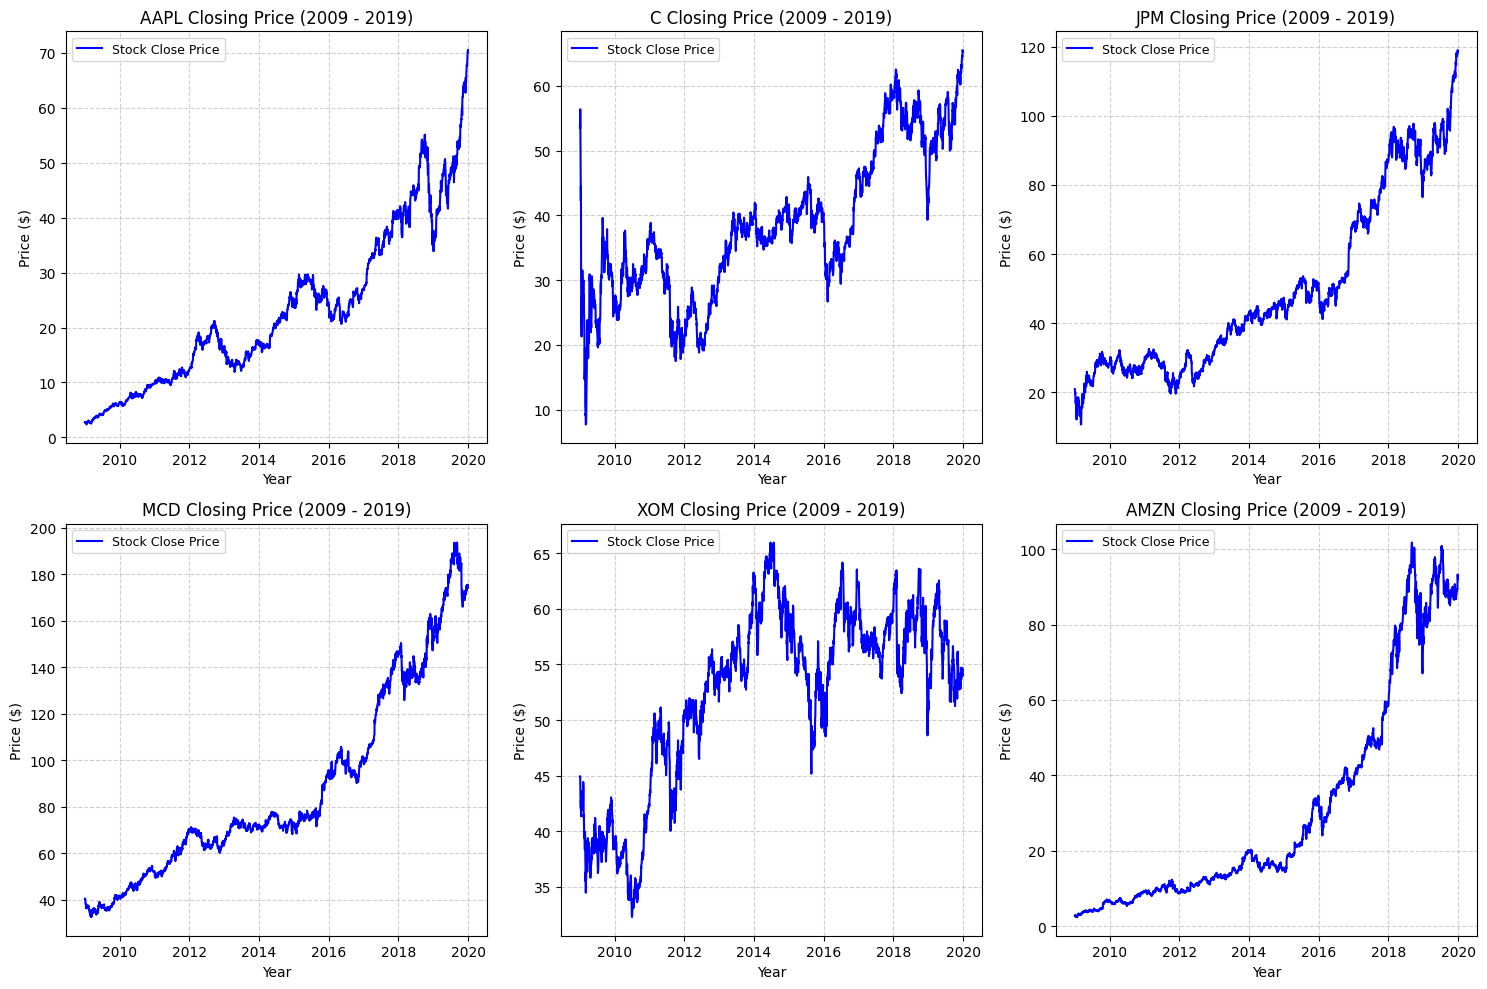

In [9]:
from AlgorithmImports import *
from QuantConnect.Data.Market import TradeBar
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import math

warnings.filterwarnings("ignore")

# Initialize the QuantBook
qb = QuantBook()

# List of stocks
# stocks = ['AAPL', 'C', 'JPM', 'MCD', 'XOM', 'AMZN']

# Create a 2x3 grid for subplots
num_rows = 2
num_cols = 3

# Create a figure for the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

# Iterate through each equity in stocks
for i, equity in enumerate(stocks):
    try:
        # Add the stock to QuantBook
        stock = qb.AddEquity(equity)

        # Define the start and end dates for historical data
        start_date = datetime(2009, 1, 1)
        end_date = datetime(2019, 12, 31)

        # Fetch the historical data
        stock_history = qb.History(stock.Symbol, start_date, end_date, Resolution.Daily)

        # Check if data is available
        if stock_history.empty:
            print(f"No data available for {equity}")
            continue

        # Extract the 'close' prices
        stock_close = stock_history['close'].unstack(level=0)

        # Determine the row and column index for the subplot
        row_index = math.floor(i / num_cols)
        col_index = i % num_cols

        # Plotting the closing prices on the specified subplot
        axes[row_index, col_index].plot(
            stock_close.index, stock_close[equity], label='Stock Close Price', color='blue', linewidth=1.5
        )
        axes[row_index, col_index].set_title(f"{equity} Closing Price (2009 - 2019)", fontsize=12)
        axes[row_index, col_index].set_xlabel('Year', fontsize=10)
        axes[row_index, col_index].set_ylabel('Price ($)', fontsize=10)
        axes[row_index, col_index].legend(loc='upper left', fontsize=9)
        axes[row_index, col_index].grid(True, linestyle='--', alpha=0.6)

    except Exception as e:
        print(f"Error processing {equity}: {e}")

# Adjust the layout and show the plots
plt.tight_layout()

# Save the figure
# plt.savefig("stocks_closing_prices.png", dpi=300)  # Save as PNG with 300 DPI


plt.show()


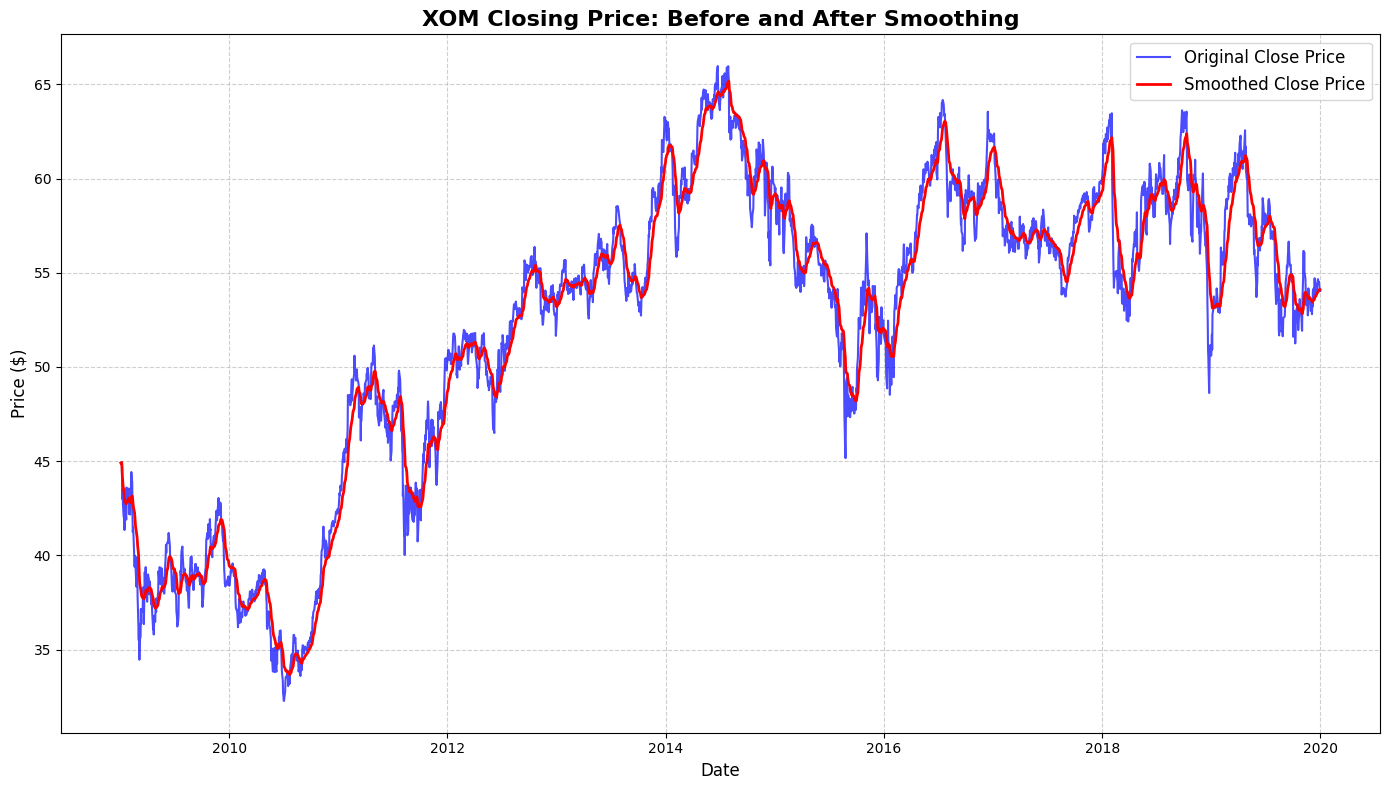

In [10]:
# Import necessary libraries
import matplotlib.pyplot as plt
import pandas as pd

# Fetch the historical data
stock = qb.AddEquity('XOM')

# Fetch historical data for the specified date range
stock_history = qb.History(stock.Symbol, start_date, end_date, Resolution.Daily)

# Ensure the data is not empty
if not stock_history.empty:
    # Convert the historical data to a DataFrame
    stock_df = stock_history.reset_index().pivot(index='time', columns='symbol', values=['open', 'high', 'low', 'close', 'volume'])
    stock_df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

    # Convert the index to a datetime format
    stock_df.index = pd.DatetimeIndex(stock_df.index)

    # Apply exponential smoothing
    stock_df['Smoothed_Close'] = stock_df['Close'].ewm(alpha=0.095).mean()

    # Plotting
    plt.figure(figsize=(14, 8))

    # Plot the original closing price
    plt.plot(
        stock_df.index,
        stock_df['Close'],
        label='Original Close Price',
        color='blue',
        linewidth=1.5,
        alpha=0.7,
    )

    # Plot the smoothed closing price
    plt.plot(
        stock_df.index,
        stock_df['Smoothed_Close'],
        label='Smoothed Close Price',
        color='red',
        linewidth=2,
    )

    # Enhancing the plot aesthetics
    plt.title("XOM Closing Price: Before and After Smoothing", fontsize=16, fontweight='bold')
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Price ($)", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    # Show the plot
    plt.show()
else:
    print("No data available for the specified date range.")


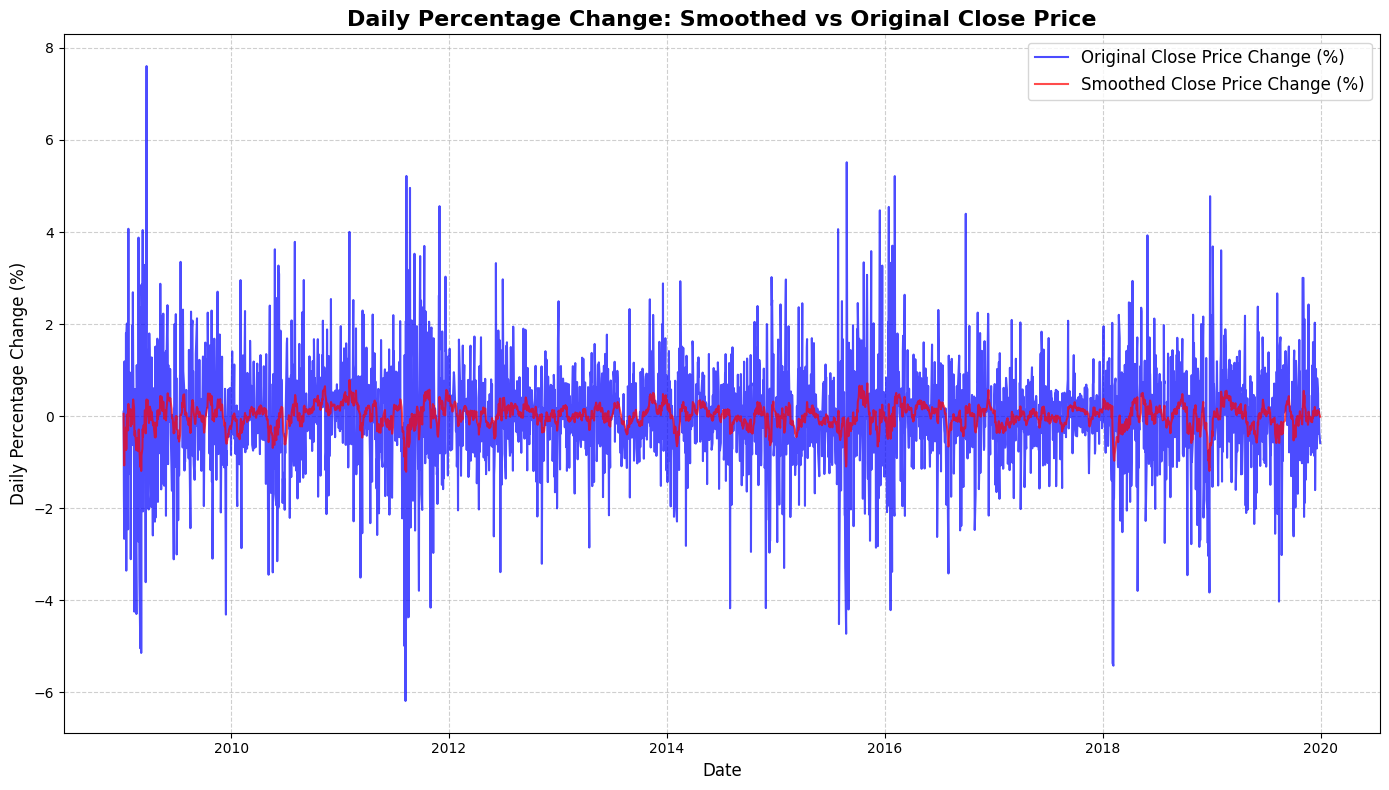

In [11]:
import matplotlib.pyplot as plt

# Calculate daily percentage change for original and smoothed close prices
stock_df['Original_Change'] = stock_df['Close'].pct_change() * 100  # Daily % change for original
stock_df['Smoothed_Change'] = stock_df['Smoothed_Close'].pct_change() * 100  # Daily % change for smoothed

# Plot the changes
plt.figure(figsize=(14, 8))

# Plot the daily percentage change for the original close price
plt.plot(
    stock_df.index,
    stock_df['Original_Change'],
    label='Original Close Price Change (%)',
    color='blue',
    linewidth=1.5,
    alpha=0.7
)

# Plot the daily percentage change for the smoothed close price
plt.plot(
    stock_df.index,
    stock_df['Smoothed_Change'],
    label='Smoothed Close Price Change (%)',
    color='red',
    linewidth=1.5,
    alpha=0.7
)

# Enhancing the plot
plt.title("Daily Percentage Change: Smoothed vs Original Close Price", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Daily Percentage Change (%)", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()


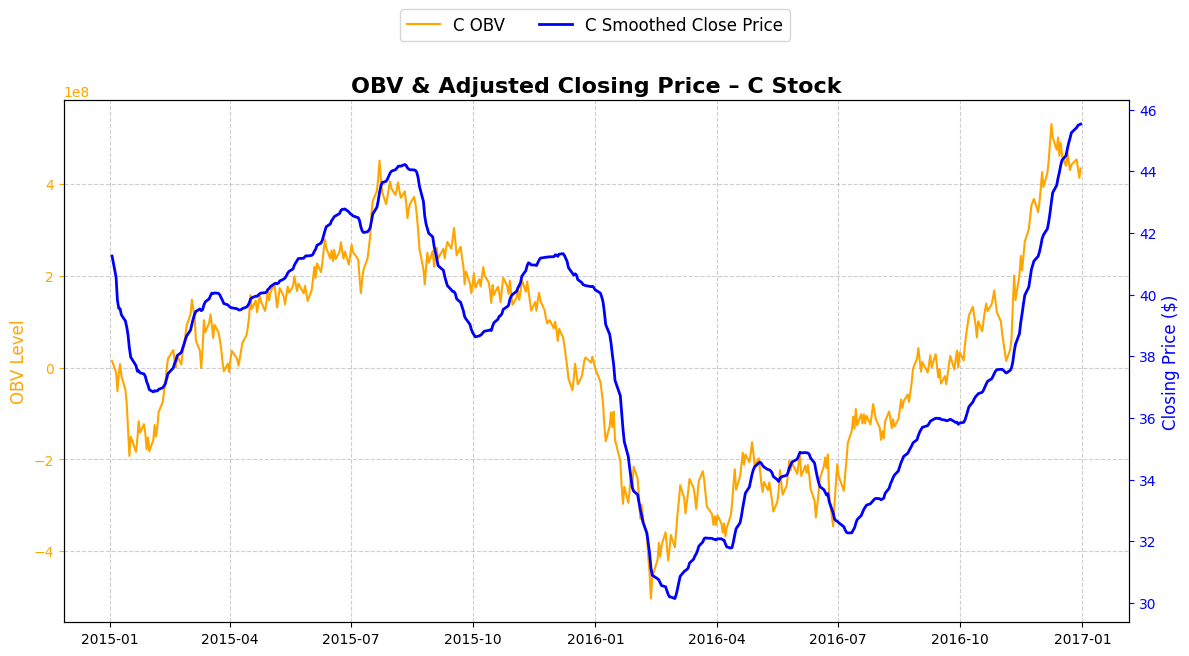

In [12]:
from AlgorithmImports import *
from QuantConnect.Data.Market import TradeBar
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import ta  # Technical Analysis library

warnings.filterwarnings("ignore")

# Initialize the QuantBook
qb = QuantBook()

# Define the stock and symbol
stock_symbol = 'C'

try:
    # Add the stock to the QuantBook
    stock_data = qb.AddEquity(stock_symbol)

    # Define the start and end dates for historical data
    start_date = datetime(2015, 1, 1)
    end_date = datetime(2016, 12, 31)

    # Fetch the historical data
    stock_history = qb.History(stock_data.Symbol, start_date, end_date, Resolution.Daily)

    # Check if data is available
    if stock_history.empty:
        print(f"No data available for {stock_symbol}")
    else:
        # Convert the historical data to a DataFrame
        stock_df = stock_history.reset_index().pivot(index='time', columns='symbol', values=['open', 'high', 'low', 'close', 'volume'])
        stock_df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
        stock_df.index = pd.DatetimeIndex(stock_df.index)

        # Smooth the data and calculate technical indicators
        stock_df['Smoothed_Close'] = stock_df['Close'].ewm(alpha=0.095).mean()
        stock_df['OBV'] = ta.volume.on_balance_volume(stock_df['Close'], stock_df['Volume'])

        # Plotting
        fig, ax1 = plt.subplots(figsize=(12, 6))

        # Plot OBV on the primary y-axis
        ax1.plot(
            stock_df.index,
            stock_df['OBV'],
            label=f'{stock_symbol} OBV',
            color='orange',
            linewidth=1.5,
        )
        ax1.set_ylabel('OBV Level', fontsize=12, color='orange')  # Match the color of the OBV line
        ax1.tick_params(axis='y', labelsize=10, colors='orange')
        ax1.grid(True, linestyle='--', alpha=0.6)

        # Add secondary y-axis for closing prices
        ax2 = ax1.twinx()
        ax2.plot(
            stock_df.index,
            stock_df['Smoothed_Close'],
            label=f'{stock_symbol} Smoothed Close Price',
            color='blue',
            linewidth=2
        )
        ax2.set_ylabel('Closing Price ($)', fontsize=12, color='blue')  # Match the color of the Smoothed_Close line
        ax2.tick_params(axis='y', labelsize=10, colors='blue')

        # Set title and x-axis label
        plt.title(f"OBV & Adjusted Closing Price – {stock_symbol} Stock", fontsize=16, fontweight='bold')
        plt.xlabel('Trading Time', fontsize=12)
        plt.xticks(fontsize=10)

        # Add legends
        fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), fontsize=12, ncol=2)

        # Adjust layout and show
        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"Error processing {stock_symbol}: {e}")



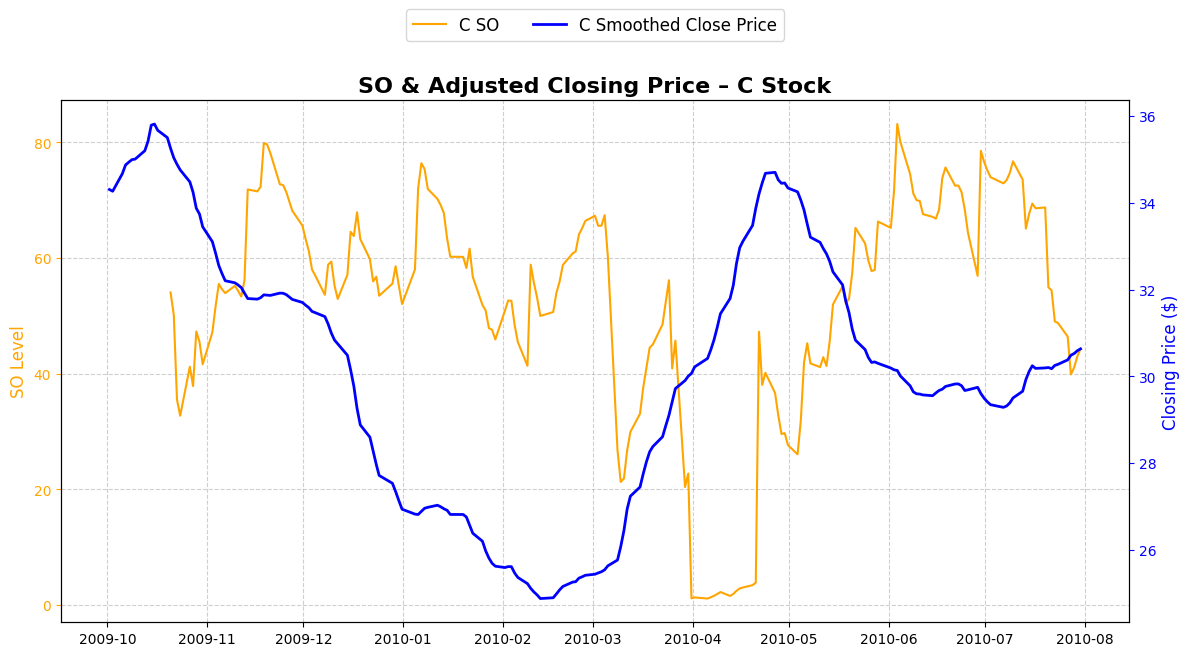

In [13]:
from AlgorithmImports import *
from QuantConnect.Data.Market import TradeBar
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import ta  # Technical Analysis library

warnings.filterwarnings("ignore")

# Initialize the QuantBook
qb = QuantBook()

# Define the stock and symbol
stock_symbol = 'C'

try:
    # Add the stock to the QuantBook
    stock_data = qb.AddEquity(stock_symbol)

    # Define the start and end dates for historical data
    start_date = datetime(2009, 10, 1)
    end_date = datetime(2010, 7, 31)

    # Fetch the historical data
    stock_history = qb.History(stock_data.Symbol, start_date, end_date, Resolution.Daily)

    # Check if data is available
    if stock_history.empty:
        print(f"No data available for {stock_symbol}")
    else:
        # Convert the historical data to a DataFrame
        stock_df = stock_history.reset_index().pivot(index='time', columns='symbol', values=['open', 'high', 'low', 'close', 'volume'])
        stock_df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
        stock_df.index = pd.DatetimeIndex(stock_df.index)

        # Smooth the data and calculate technical indicators
        stock_df['Smoothed_Close'] = stock_df['Close'].ewm(alpha=0.095).mean()
        stock_df['OBV'] = ta.volume.on_balance_volume(stock_df['Close'], stock_df['Volume'])
        stock_df['SO'] = ta.momentum.stoch(stock_df['High'], stock_df['Low'], stock_df['Smoothed_Close'])
        stock_df['MACD'] = ta.trend.macd_diff(stock_df['Smoothed_Close'])

        # Plotting
        fig, ax1 = plt.subplots(figsize=(12, 6))

        # Plot OBV on the primary y-axis
        ax1.plot(
            stock_df.index,
            stock_df['SO'],
            label=f'{stock_symbol} SO',
            color='orange',
            linewidth=1.5,
        )
        ax1.set_ylabel('SO Level', fontsize=12, color='orange')  # Match the color of the OBV line
        ax1.tick_params(axis='y', labelsize=10, colors='orange')
        ax1.grid(True, linestyle='--', alpha=0.6)

        # Add secondary y-axis for closing prices
        ax2 = ax1.twinx()
        ax2.plot(
            stock_df.index,
            stock_df['Smoothed_Close'],
            label=f'{stock_symbol} Smoothed Close Price',
            color='blue',
            linewidth=2
        )
        ax2.set_ylabel('Closing Price ($)', fontsize=12, color='blue')  # Match the color of the Smoothed_Close line
        ax2.tick_params(axis='y', labelsize=10, colors='blue')


        # Set title and x-axis label
        plt.title(f"SO & Adjusted Closing Price – {stock_symbol} Stock", fontsize=16, fontweight='bold')
        plt.xlabel('Trading Time', fontsize=12)
        plt.xticks(fontsize=10)

        # Add legends
        fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), fontsize=12, ncol=2)

        # Adjust layout and show
        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"Error processing {stock_symbol}: {e}")



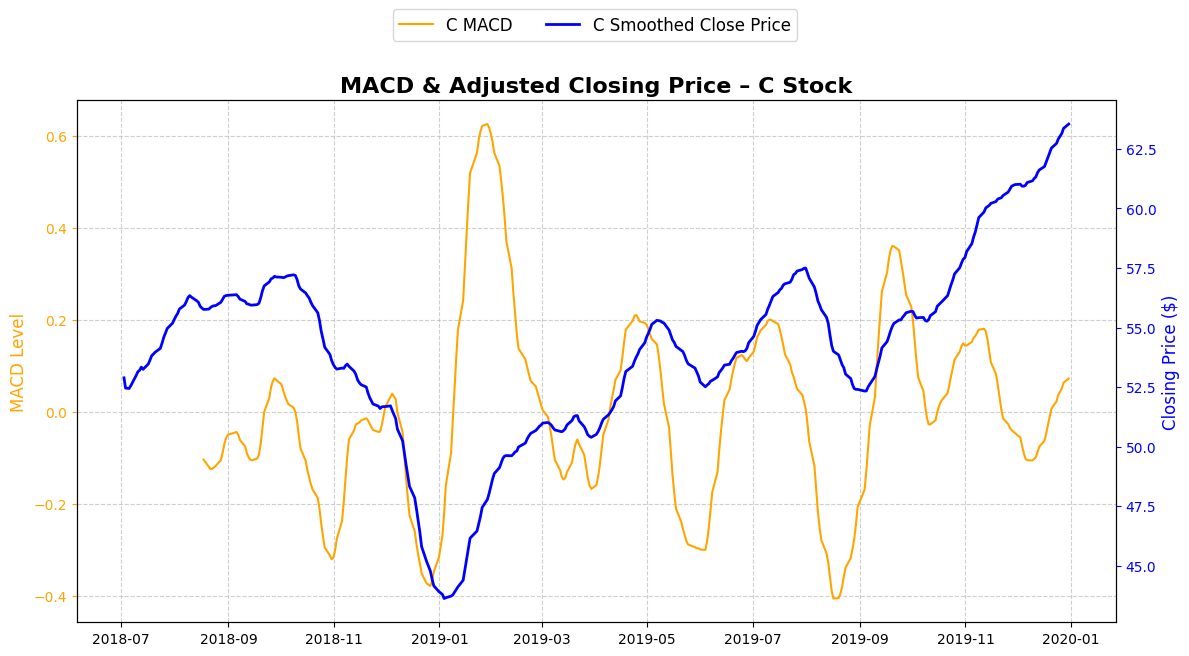

In [14]:
from AlgorithmImports import *
from QuantConnect.Data.Market import TradeBar
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import ta  # Technical Analysis library

warnings.filterwarnings("ignore")

# Initialize the QuantBook
qb = QuantBook()

# Define the stock and symbol
stock_symbol = 'C'

try:
    # Add the stock to the QuantBook
    stock_data = qb.AddEquity(stock_symbol)

    # Define the start and end dates for historical data
    start_date = datetime(2018, 7, 1)
    end_date = datetime(2019, 12, 31)

    # Fetch the historical data
    stock_history = qb.History(stock_data.Symbol, start_date, end_date, Resolution.Daily)

    # Check if data is available
    if stock_history.empty:
        print(f"No data available for {stock_symbol}")
    else:
        # Convert the historical data to a DataFrame
        stock_df = stock_history.reset_index().pivot(index='time', columns='symbol', values=['open', 'high', 'low', 'close', 'volume'])
        stock_df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
        stock_df.index = pd.DatetimeIndex(stock_df.index)

        # Smooth the data and calculate technical indicators
        stock_df['Smoothed_Close'] = stock_df['Close'].ewm(alpha=0.095).mean()
        stock_df['OBV'] = ta.volume.on_balance_volume(stock_df['Close'], stock_df['Volume'])
        stock_df['SO'] = ta.momentum.stoch(stock_df['High'], stock_df['Low'], stock_df['Smoothed_Close'])
        stock_df['MACD'] = ta.trend.macd_diff(stock_df['Smoothed_Close'])

        # Plotting
        fig, ax1 = plt.subplots(figsize=(12, 6))

        # Plot OBV on the primary y-axis
        ax1.plot(
            stock_df.index,
            stock_df['MACD'],
            label=f'{stock_symbol} MACD',
            color='orange',
            linewidth=1.5,
        )
        ax1.set_ylabel('MACD Level', fontsize=12, color='orange')  # Match the color of the OBV line
        ax1.tick_params(axis='y', labelsize=10, colors='orange')
        ax1.grid(True, linestyle='--', alpha=0.6)

        # Add secondary y-axis for closing prices
        ax2 = ax1.twinx()
        ax2.plot(
            stock_df.index,
            stock_df['Smoothed_Close'],
            label=f'{stock_symbol} Smoothed Close Price',
            color='blue',
            linewidth=2
        )
        ax2.set_ylabel('Closing Price ($)', fontsize=12, color='blue')  # Match the color of the Smoothed_Close line
        ax2.tick_params(axis='y', labelsize=10, colors='blue')


        # Set title and x-axis label
        plt.title(f"MACD & Adjusted Closing Price – {stock_symbol} Stock", fontsize=16, fontweight='bold')
        plt.xlabel('Trading Time', fontsize=12)
        plt.xticks(fontsize=10)

        # Add legends
        fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), fontsize=12, ncol=2)

        # Adjust layout and show
        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"Error processing {stock_symbol}: {e}")



In [15]:

import pandas as pd

pd.set_option("display.max_rows", None)  # Show all rows
pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.max_colwidth", None)  # No column width truncation



In [16]:
print(stocks)

['AAPL', 'C', 'JPM', 'MCD', 'XOM', 'AMZN']


In [17]:
train_test_accuracy_dict['XOM']['Train-test start date'] = pd.to_datetime(train_test_accuracy_dict['XOM']['Train-test start date']).dt.date
train_test_accuracy_dict['XOM']['Window end'] = pd.to_datetime(train_test_accuracy_dict['XOM']['Window end']).dt.date

train_test_accuracy_dict['XOM']

,Train-test start date,Window end,Testing accuracy XGB,Recall XGB,Precision XGB,F1 XGB,Testing accuracy RF,Recall RF,Precision RF,F1 RF
0,2009-01-02,2017-10-16,0.839729,0.879032,0.841699,0.859961,0.837472,0.862903,0.849206,0.856000
1,2009-02-03,2017-11-14,0.846501,0.896154,0.850365,0.872659,0.844244,0.880769,0.857678,0.869070
2,2009-03-05,2017-12-14,0.821670,0.865306,0.821705,0.842942,0.826185,0.848980,0.838710,0.843813
3,2009-04-03,2018-01-17,0.837472,0.879032,0.838462,0.858268,0.846501,0.870968,0.857143,0.864000
4,2009-05-05,2018-02-15,0.828442,0.878151,0.816406,0.846154,0.830700,0.861345,0.829960,0.845361
5,2009-06-04,2018-03-19,0.830700,0.866359,0.803419,0.833703,0.835214,0.843318,0.824324,0.833713
6,2009-07-06,2018-04-18,0.823928,0.859903,0.784141,0.820276,0.828442,0.855072,0.793722,0.823256
7,2009-08-04,2018-05-17,0.835214,0.853881,0.820175,0.836689,0.841986,0.858447,0.828194,0.843049
8,2009-09-02,2018-06-18,0.835214,0.898678,0.803150,0.848233,0.835214,0.885463,0.810484,0.846316
9,2009-10-02,2018-07-18,0.826185,0.894068,0.802281,0.845691,0.828442,0.881356,0.812500,0.845528


In [18]:
predictions_table_dict['AMZN']['Date'] = pd.to_datetime(predictions_table_dict['AMZN']['Date']).dt.date

predictions_table_dict['AMZN']

,Date,Actual,XGB_Prediction,RF_Prediction
0,2017-11-15,1,1,1
1,2017-12-15,1,1,1
2,2018-01-18,1,1,1
3,2018-02-16,1,1,1
4,2018-03-20,1,1,1
5,2018-04-19,-1,-1,-1
6,2018-05-18,1,1,1
7,2018-06-19,1,1,1
8,2018-07-19,1,1,1
9,2018-08-17,1,1,1


In [19]:
best_params_dict

{'AAPL_rf': {'bootstrap': False, 'max_depth': 5, 'n_estimators': 50},
 'AAPL_xgb': {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300},
 'C_rf': {'bootstrap': True, 'max_depth': 5, 'n_estimators': 50},
 'C_xgb': {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100},
 'JPM_rf': {'bootstrap': True, 'max_depth': 5, 'n_estimators': 100},
 'JPM_xgb': {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100},
 'MCD_rf': {'bootstrap': True, 'max_depth': 5, 'n_estimators': 300},
 'MCD_xgb': {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200},
 'XOM_rf': {'bootstrap': True, 'max_depth': 5, 'n_estimators': 100},
 'XOM_xgb': {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300},
 'AMZN_rf': {'bootstrap': False, 'max_depth': 5, 'n_estimators': 300},
 'AMZN_xgb': {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}}